In [1]:
import pandas as pd
import geopandas
import matplotlib.pyplot as plt
import os
import random
import pandapower as pp
import pandapower.networks as ppnets

In [2]:
CASE    = 'case118pp'
if CASE== 'case118pp':
    net =  ppnets.case118()

In [3]:
net

This pandapower network includes the following parameter tables:
   - bus (118 elements)
   - load (99 elements)
   - gen (53 elements)
   - shunt (14 elements)
   - ext_grid (1 element)
   - line (173 elements)
   - trafo (13 elements)
   - poly_cost (54 elements)
   - bus_geodata (118 elements)

In [4]:
total_active_load=net.load.p_mw.sum(); total_reactive_load=net.load.q_mvar.sum()
total_active_load,total_reactive_load

(4242.0, 1438.0)

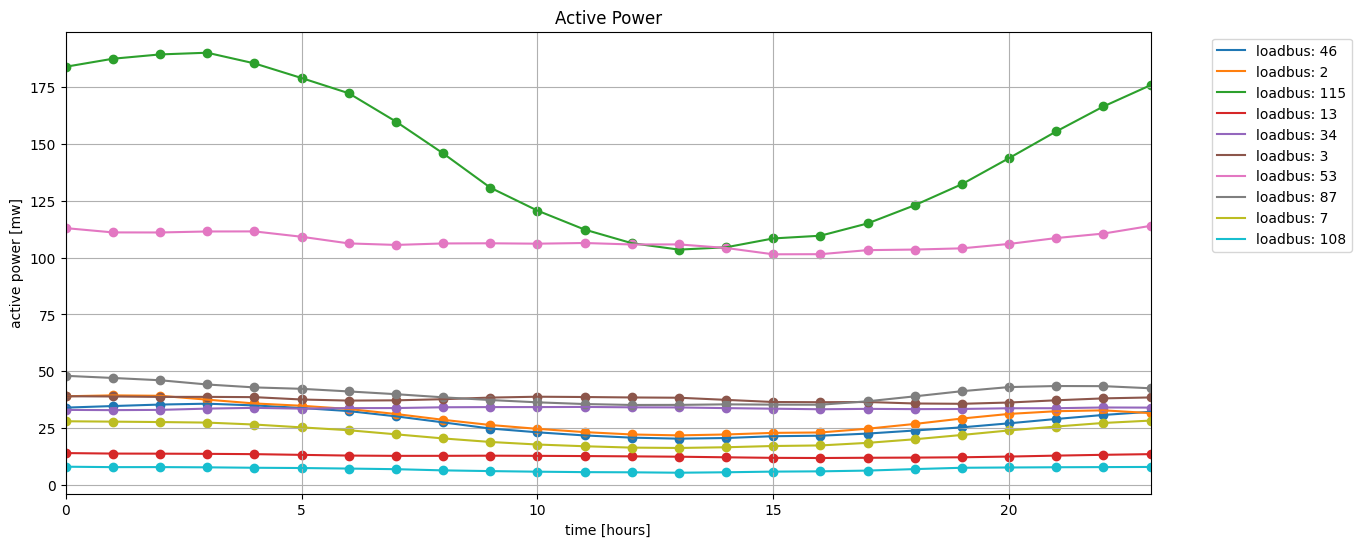

In [5]:
# if we want to work with existing file - other skip

df_118_load=pd.read_excel('C:\\Users\\Coham\\OneDrive\\Desktop\\pyscripts\\projects\\loads\\data\\loads_case118.xlsx')

#df_118_load.p_mw=df_118_load.p_mw*aps
#df_118_load.q_mvar=df_118_load.q_mvar*aps
y1=[] ; y2=[]
for i in range(24):
    y1.append(df_118_load.p_mw[df_118_load.scenario==i].sum())
    y2.append(df_118_load.q_mvar[df_118_load.scenario==i].sum())

bus=list(df_118_load.bus.unique())

plt.figure(figsize=(14,6))
plt.xlim(0,23)
plt.xlabel('time [hours]'); plt.ylabel('active power [mw]'); plt.title('Active Power')

# pick randomly 10 buses from 
bus_to_plot=random.sample(bus,10)
for ix in bus_to_plot:
    plt.scatter(range(0,24),df_118_load[df_118_load.bus==ix].p_mw)
    plt.plot(range(0,24),df_118_load[df_118_load.bus==ix].p_mw,label='loadbus: '+str(ix))

plt.grid(True)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()


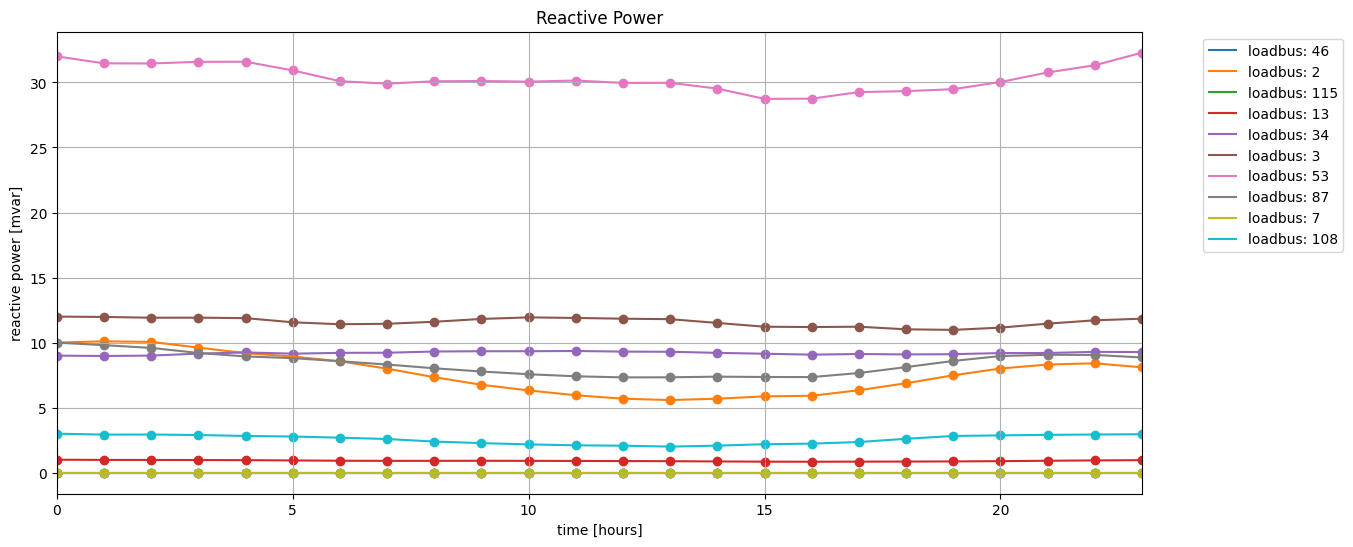

In [6]:
plt.figure(figsize=(14,6))
plt.xlim(0,23)
plt.xlabel('time [hours]'); plt.ylabel('reactive power [mvar]'); plt.title('Reactive Power')

for ix in bus_to_plot:
    plt.scatter(range(0,24),df_118_load[df_118_load.bus==ix].q_mvar)
    plt.plot(range(0,24),df_118_load[df_118_load.bus==ix].q_mvar,label='loadbus: '+str(ix))

plt.grid(True)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

In [7]:
for i in y2:
    print(round(i,0), end="   ")

1438.0   1437.0   1435.0   1420.0   1383.0   1336.0   1287.0   1219.0   1148.0   1083.0   1035.0   997.0   969.0   954.0   958.0   972.0   980.0   1023.0   1081.0   1148.0   1220.0   1287.0   1344.0   1389.0   

In [ ]:
# load texas load data from Marcus
parquet_filepath = 'C:\\Users\\Coham\\OneDrive\\Desktop\\pyscripts\\projects\\loads\\data\\df_load_buses.parquet'
df_texas_loads = pd.read_parquet(parquet_filepath)
df_texas_loads.set_index('timestamp_cdt', inplace=True)
df_texas_loads.tail(2)

# note that this is one year worth of data: 365*24*2000(buses)= 17520000

In [ ]:
# pick a 24 hour window
start_date = '2022-08-04 14:30:00-06:00'
end_date = '2022-08-05 13:30:00-06:00'
bus_id=1227
plt.figure(figsize=(12, 6))
sub=df_texas_loads[df_texas_loads.bus_id==bus_id].loc[start_date:end_date]
plt.scatter(sub.index,sub['load'])
time_idx=sub.index

In [ ]:
#options = list(range(1, 2001))  # Numbers from 1 to 2000
# Pick 99 unique random items
#selection = random.sample(options, 99)
#print("Random selection:", selection)
bus_idx=[1227, 1243, 1497, 271, 52, 872, 574, 142, 1999, 816, 105, 1453, 1991, 257, 1988, 76, 920, 678, 1877, 1523, 645, 1528, 1, 1646, 1125, 637, 195, 296, 6, 1207, 380, 220, 721, 1177, 1228, 198, 1409, 1225, 1218, 1944, 917, 1789, 250, 1917, 1886, 1922, 1776, 1190, 287, 689, 1273, 1268, 130, 1898, 1649, 1270, 1992, 889, 1099, 1943, 204, 1278, 1199, 1858, 461, 1286, 154, 140, 1425, 1955, 1470, 1876, 229, 399, 811, 614, 445, 930, 1208, 1000, 1036, 764, 633, 398, 1916, 57, 1328, 1372, 347, 834, 386, 541, 1847, 498, 949, 1547, 1167, 265, 284]

In [ ]:
# profile for a given bus across 24 hours 
df_scale=pd.DataFrame()
for bx in bus_idx:
    s=list(df_texas_loads.load[df_texas_loads.bus_id==bx].loc[time_idx])
    l=[]
    for x in s:
        l.append(x/s[0]) 
    df_scale[str(bx)]=l

# all scaling factors:
#df_scale=df_scale.transpose()
df_scale.head()

In [ ]:
df_118_load=net.load.copy()
df_118_load.insert(0,'scenario',[0]*99)

for i in range(len(bus_idx)):
    df_118_load.name.iloc[i]=bus_idx[i]

df_app = df_118_load.loc[:, :].copy()
df_app.head()
for hour in range(1,24):
    i=0
    for bx in bus_idx:
        df_app.name.iloc[i]=bx
        df_app.scenario=hour
        df_app.p_mw.iloc[i]  =net.load.p_mw.iloc[i]*df_scale[str(bx)].iloc[hour]
        df_app.q_mvar.iloc[i]=net.load.q_mvar.iloc[i]*df_scale[str(bx)].iloc[hour]
        i=i+1
    df_118_load=pd.concat([df_118_load,df_app], ignore_index=True)

#df_118_load.head()

#for hour in range(1,24):
#    print(hour,end ="---")
#    for bx in bus_idx:
#        df_app.scenario.iloc[i]=hour
#        df_scale[bx].iloc[hour]

        
        #p_mw=df_texas_loads.load[df_texas_loads.bus_id==bus_idx[i]].loc[time_idx[hour]]
        #df_app.p_mw.iloc[i]=p_mw
        #df_app.q_mvar.iloc[i]=p_mw/2.0
#    df_118_load=pd.concat([df_118_load,df_app], ignore_index=True)

In [8]:
################################

In [9]:
df_118_load.to_excel('C:\\Users\\Coham\\OneDrive\\Desktop\\pyscripts\\projects\\loads\\data\\loads_case118.xlsx', index=False)

In [10]:
df_118_load.head(5)

,scenario,name,bus,p_mw,q_mvar,const_z_percent,const_i_percent,sn_mva,scaling,in_service,type,controllable
0,0,1227,0,51.0,27.0,0,0,NaN,1,True,NaN,False
1,0,1243,1,20.0,9.0,0,0,NaN,1,True,NaN,False
2,0,1497,2,39.0,10.0,0,0,NaN,1,True,NaN,False
3,0,271,3,39.0,12.0,0,0,NaN,1,True,NaN,False
4,0,52,5,52.0,22.0,0,0,NaN,1,True,NaN,False


In [11]:
df_118_load.tail(5)

,scenario,name,bus,p_mw,q_mvar,const_z_percent,const_i_percent,sn_mva,scaling,in_service,type,controllable
2371,23,949,113,7.971906,2.989465,0,0,NaN,1,True,NaN,False
2372,23,1547,114,16.878743,5.370509,0,0,NaN,1,True,NaN,False
2373,23,1167,115,175.914352,0.000000,0,0,NaN,1,True,NaN,False
2374,23,265,116,19.744021,7.897608,0,0,NaN,1,True,NaN,False
2375,23,284,117,32.570315,14.804689,0,0,NaN,1,True,NaN,False


In [12]:
# increments for active and passive power
increment_active=[0,20,40,60,80,100]
divisor=3.0
increment_passive = [x / divisor for x in increment_active]

In [ ]:
#plt.plot(df_118_training.p_mw[df_118_training.bus==0])

In [ ]:
# let's create an index 

# load# - time# - bus# - increment_active # - increment_passive #
# 2-5-12-35-17.5 means load profile #2, timestamp #5, load bus # 12, and increment active power #35 [in MW] and increment passive power 17.5 [in MVAR]

In [67]:
df_118_training=df_118_load.copy()
#df_118_training.columns[5:]
df_118_training.drop(columns=['const_z_percent', 'const_i_percent', 'sn_mva', 'scaling', 'in_service','type', 'controllable'],inplace=True)
df_118_training['active_increment']=[0] * 2376 ; df_118_training['reactive_increment']=[0]*2376

df_base=df_118_training.copy()
for i in range(1,len(increment_active)):
    df_app=df_base.copy()
    for bx in df_118_training.bus.unique():    
        df_app.p_mw[df_app.bus==bx]=df_app.p_mw[df_app.bus==bx]+increment_active[i]
        df_app.q_mvar[df_app.bus==bx]=df_app.q_mvar[df_app.bus==bx]+increment_passive[i]
        df_app.active_increment[df_app.bus==bx]=increment_active[i]
        df_app.reactive_increment[df_app.bus==bx]=increment_passive[i]
        df_118_training=pd.concat([df_118_training,df_app], ignore_index=True)

In [69]:
df_118_training.to_csv("loads_case118_training.csv", index=False)

In [2]:
24*99+(24*99)*99*5

1178496

In [7]:
11*24+(11*24)*11*35

101904

In [51]:
df_118_training=df_118_load.copy()
#df_118_training.columns[5:]
df_118_training.drop(columns=['const_z_percent', 'const_i_percent', 'sn_mva', 'scaling', 'in_service','type', 'controllable'],inplace=True)
    

In [52]:
df_118_training['active_increment']=[0] * 2376 ; df_118_training['reactive_increment']=[0]*2376

In [53]:
df_118_training.head()

,scenario,name,bus,p_mw,q_mvar,active_increment,reactive_increment
0,0,1227,0,51.0,27.0,0,0
1,0,1243,1,20.0,9.0,0,0
2,0,1497,2,39.0,10.0,0,0
3,0,271,3,39.0,12.0,0,0
4,0,52,5,52.0,22.0,0,0
